In [1]:
%load_ext autoreload
%autoreload 2

In [47]:
import itertools
import torch
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from scipy import stats

from cvae_train import PETDataset, load_model, cVAE_PET
from demographics import get_age_and_education, merge_tables, create_merged_table
from post_hoc import (get_ad_baseline_ids, get_amy_positive_ids, get_posthoc_vars, 
                      run_group_tests, compute_conversion_times, compute_mci_conversion_times, 
                      km_curve, run_pairwise_tests)

In [3]:
DEVICE = (f'cuda:0' if torch.cuda.is_available() else 'cpu')

In [4]:
all_cohorts_path = '/home/hice1/khom9/CS8903/all_cohorts_cvae.csv'
ad_hdf5_path = '/home/hice1/khom9/scratch/ADNI_Data/cVAE/AD_Cohort.hdf5'
mci_hdf5_path = '/home/hice1/khom9/scratch/ADNI_Data/cVAE/MCI_Cohort.hdf5'
cn_hdf5_path = '/home/hice1/khom9/scratch/ADNI_Data/cVAE/CN_Cohort.hdf5'

In [5]:
ad_dataset = PETDataset(ad_hdf5_path, all_cohorts_path, normalize='scale')
mci_dataset = PETDataset(mci_hdf5_path, all_cohorts_path, diagnosis=2, normalize='scale')
dataset = ad_dataset

In [6]:
latent_dim = 10
model = cVAE_PET(latent_dim).to(DEVICE)
save_path = 'cvae-models/cvae_ad_scale.pth'
model = load_model(model, save_path)

/home/hice1/khom9/.local/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [7]:
model.eval()
with torch.no_grad():
    _, mu, logvar = model(torch.Tensor(dataset.imgs).unsqueeze(1).to(DEVICE), torch.Tensor(dataset.cdr_scores).to(DEVICE))
    mu = mu.cpu().numpy()
    
kmeans = KMeans(n_clusters=4)
clust = kmeans.fit_predict(mu)

In [8]:
# Post-hoc analysis
PET_METADATA_PATH = 'All_Preprocessed_PET.csv'
DEMOGRAPHIC_PATH = 'All_Subjects_Demographic.csv'
CDRSB_PATH = 'All_Subjects_CDR.csv'
MMSE_PATH = 'MMSE.csv'
MOCA_PATH = 'MOCA.csv'
AV45_PATH = 'All_Subjects_UCBERKELEY_AMY_6MM.csv'
APOE_PATH = 'All_Subjects_APOERES.csv'
PHC_PATH = 'ADSP_PHC_COGN.csv'
CSF_PATH = 'All_Subjects_UPENNBIOMK_ROCHE_ELECSYS.csv'

In [9]:
# Perform statistical tests with all AD images
ad_vars = get_posthoc_vars(ad_dataset.img_ids, clust)

In [10]:
# Perform statistical tests with images from patients diagnosed with AD at baseline visit.
ad_baseline_ids = get_ad_baseline_ids()  
ad_baseline_ids = [ad_id for ad_id in dataset.img_ids if ad_id in ad_baseline_ids]
ad_baseline_clust = [clust[i] for i in range(len(dataset.img_ids)) if dataset.img_ids[i] in ad_baseline_ids]

ad_baseline_vars = get_posthoc_vars(ad_baseline_ids, ad_baseline_clust)

In [11]:
# Perform statistical tests with images from patients with amyloid positive status (whole cerebellum AV45 SUVR > 1.11)
ad_amy_ids = get_amy_positive_ids()
ad_amy_ids = [ad_id for ad_id in dataset.img_ids if ad_id in ad_amy_ids]
ad_amy_clust = [clust[i] for i in range(len(dataset.img_ids)) if dataset.img_ids[i] in ad_amy_ids]

ad_amy_vars = get_posthoc_vars(ad_amy_ids, ad_amy_clust)

In [12]:
# Perform statistical tests with images from MCI patients
model.eval()
with torch.no_grad():
    _, mu, logvar = model(torch.Tensor(mci_dataset.imgs).unsqueeze(1).to(DEVICE), torch.Tensor(mci_dataset.cdr_scores).to(DEVICE))
    mu = mu.cpu().numpy()
    
kmeans = KMeans(n_clusters=4)
mci_clust = kmeans.fit_predict(mu)
mci_vars = get_posthoc_vars(mci_dataset.img_ids, mci_clust)

In [33]:
# ad_vars.to_csv('ad_vars.csv', index=True)

In [34]:
# ad_baseline_vars.to_csv('ad_baseline_vars.csv',index=True)

In [35]:
# ad_amy_vars.to_csv('ad_amy_vars.csv',index=True)

In [36]:
# mci_vars.to_csv('mci_vars.csv', index=True)

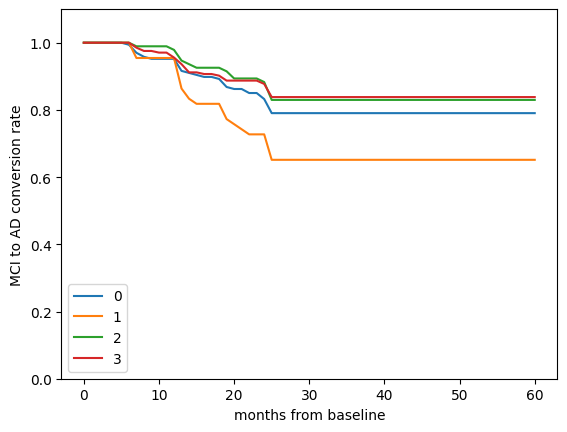

In [90]:
all_cohorts = pd.read_csv(all_cohorts_path, parse_dates=['EXAMDATE'])
dxsum = pd.read_csv('All_Subjects_DXSUM.csv', parse_dates=['EXAMDATE'])
times = []

fig, ax = plt.subplots()
for c in [0,1,2,3]:
    ad_vars_clust = ad_vars[ad_vars['cluster'] == c]
    df = dxsum[dxsum['PTID'].isin(ad_vars_clust['subject_id'])]
    followup, n_subjects = compute_conversion_times(df)
#     m_time = np.sum(followup * np.arange(len(followup))) / n_subjects
#     print('n_subjects', n_subjects)
    vals = km_curve(followup, n_subjects)
    ax.plot(vals, label=c)
#     print(m_time)
    
    times.append([[i] * int(followup[i]) for i in range(len(followup))])

times = [list(itertools.chain(*subtype_times)) for subtype_times in times]
ax.set_ylim(0,1.1)
ax.set_xlabel('months from baseline')
ax.set_ylabel('MCI to AD conversion rate')
plt.legend()

In [ ]:
compute_mci_conversion_times()

In [20]:
# Calculate p-value for conversion times
stats.f_oneway(*times)

F_onewayResult(statistic=3.330542674859012, pvalue=0.02062593237301016)

In [21]:
var_names = ['PTEDUCAT', 'PTGENDER', 'age', 'CDRSB', 'MMSCORE', 'MOCA', 'SUMMARY_SUVR', 'PHC_VSP', 'PHC_LAN', 'PHC_MEM', 'PHC_EXF', 'TAU', 'PTAU', 'ABETA42']
test_names = ['anova'] * len(var_names)
df_names = ['ad','ad_baseline','ad_amy','mci']

res_df = pd.DataFrame(index=var_names)

for i,df in enumerate([ad_vars, ad_baseline_vars, ad_amy_vars, mci_vars]):
    f_vals, p_vals = run_group_tests(df, var_names, test_names)
    res_df[df_names[i]] = pd.Series(index=var_names, data=p_vals)
res_df

,ad,ad_baseline,ad_amy,mci
PTEDUCAT,7.774490e-08,0.000034,1.272290e-03,9.909107e-02
PTGENDER,2.248437e-19,0.000007,2.664357e-10,1.436575e-33
age,7.422300e-02,0.322925,8.579158e-01,1.898610e-11
CDRSB,6.864246e-01,0.555381,2.925987e-01,1.323032e-03
MMSCORE,1.276133e-01,0.972579,6.843229e-01,1.563968e-02
MOCA,9.058551e-02,0.141974,1.785552e-01,6.920000e-01
SUMMARY_SUVR,2.618356e-01,0.499678,7.041130e-01,1.969598e-03
PHC_VSP,4.519479e-01,0.662936,9.428943e-02,1.064420e-05
PHC_LAN,5.407978e-01,0.882792,8.720650e-01,5.044183e-07
PHC_MEM,6.758179e-01,0.921680,9.549437e-01,1.715649e-07


In [31]:
def prettify_col(col):
    col = col.copy()
    for var_name in col.index:
        if float(col[var_name]) < 0.001:
            col[var_name] = '<0.001**'
        elif float(col[var_name]) < 0.01:
            col[var_name] = '<0.01**'
        elif float(col[var_name]) < 0.05:
            col[var_name] = '<0.05*'
        else:
            col[var_name] = f'{float(col[var_name]):.4f}'
    return col

def pval_prettyprint(df, new_index=None):
    '''
    Print a dataframe of p-values that:
    - Replaces values <0.001 with "< 0.001***"
    - Replaces values with <0.01 with "< 0.01**"
    - Replaces values with <0.05 with "< 0.05*"
    '''
    for col_name in df.columns:
        col = df[col_name].astype(str)
#         for var_name in col.index:
#             if float(col[var_name]) < 0.001:
#                 col[var_name] = '<0.001**'
#             elif float(col[var_name]) < 0.01:
#                 col[var_name] = '<0.01**'
#             elif float(col[var_name]) < 0.05:
#                 col[var_name] = '<0.05*'
#             else:
#                 col[var_name] = f'{float(col[var_name]):.4f}'
        df[col_name] = prettify_col(col)
    if new_index is not None:
        df.index = new_index
    return df
        

In [32]:
pairwise_ad = run_pairwise_tests(ad_vars, var_names)
pretty_index = ['education', 'gender (% female)', 'age', 'CDR-SB', 'MMSE', 'MOCA', 'AV45 SUVR', 
                'visuospatial score', 'language score', 'memory score', 'executive score', 
                'CSF total tau', 'CSF p-tau', 'CSF amyloid-beta']
pval_prettyprint(pairwise_ad, new_index=pretty_index)

/home/hice1/khom9/.local/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


,0 vs 1,0 vs 2,0 vs 3,1 vs 2,1 vs 3,2 vs 3
education,<0.01**,<0.001**,0.1691,<0.001**,0.0616,<0.001**
gender (% female),<0.001**,<0.001**,<0.001**,<0.001**,0.3225,<0.001**
age,<0.05*,0.2841,<0.05*,0.3211,0.4998,0.6117
CDR-SB,0.3393,0.6901,0.7027,0.2453,0.5660,0.4833
MMSE,0.3121,0.1414,0.6540,<0.05*,0.1438,0.2429
MOCA,<0.001**,0.5018,0.9128,<0.001**,<0.001**,0.4668
AV45 SUVR,0.0783,0.7442,0.5998,0.1274,0.1097,0.9792
visuospatial score,0.3409,0.1475,0.2635,0.5177,0.9486,0.5263
language score,0.4769,0.3678,0.8513,0.1507,0.3751,0.4498
memory score,0.5572,0.4850,0.7642,0.2530,0.3766,0.6316


In [83]:
# Print group test dataframes
ad_group_tests = pd.read_csv('ad_group_tests.csv', index_col=0)
ad_group_tests.index = pretty_index
ad_group_tests

,pval,0,1,2,3
education,<0.001**,15.5745 (2.873),14.7033 (3.076),16.6212 (2.621),15.2310 (2.789)
gender (% female),<0.001**,1.6170 (0.486),1.3681 (0.482),1.1288 (0.335),1.4138 (0.493)
age,0.0742,75.4789 (7.835),77.2463 (6.638),76.4021 (7.911),76.8115 (7.029)
CDR-SB,0.6864,5.4191 (2.407),5.1978 (2.282),5.5303 (2.629),5.3328 (2.764)
MMSE,0.1276,22.1880 (3.835),22.5714 (3.813),21.5000 (4.497),22.0345 (3.953)
MOCA,0.0906,17.3214 (3.606),10.0000 (0.000),18.3529 (5.379),17.2069 (4.105)
AV45 SUVR,0.2618,1.4313 (0.244),1.2837 (0.272),1.4174 (0.307),1.4163 (0.255)
visuospatial score,0.4519,-0.1386 (0.785),-0.2120 (0.771),-0.2750 (0.899),-0.2167 (0.805)
language score,0.5408,-0.3065 (0.614),-0.2617 (0.652),-0.3692 (0.650),-0.3170 (0.666)
memory score,0.6758,-0.9008 (0.486),-0.8726 (0.483),-0.9406 (0.541),-0.9139 (0.504)


In [85]:
ad_baseline_group_tests = pd.read_csv('ad_baseline_group_tests.csv', index_col=0)
ad_baseline_group_tests.index = pretty_index
ad_baseline_group_tests

,pval,0,1,2,3
education,<0.001**,15.0538 (2.875),14.6000 (3.083),17.0980 (2.522),15.1228 (2.643)
gender (% female),<0.001**,1.5699 (0.495),1.3667 (0.482),1.1373 (0.344),1.4035 (0.491)
age,0.3229,74.0681 (8.154),76.1827 (6.803),74.1536 (8.282),75.7358 (7.745)
CDR-SB,0.5554,4.7043 (1.740),4.3000 (1.370),4.3725 (1.421),4.4737 (1.798)
MMSE,0.9726,23.1505 (2.209),23.3667 (2.359),23.2353 (2.006),23.1930 (2.220)
MOCA,0.1420,17.5714 (3.698),10.0000 (0.000),17.7000 (5.423),16.7368 (3.891)
AV45 SUVR,0.4997,1.4442 (0.233),1.6925 (0.084),1.4261 (0.284),1.4234 (0.254)
visuospatial score,0.6629,-0.1473 (0.729),-0.3124 (0.772),-0.1814 (0.808),-0.1195 (0.753)
language score,0.8828,-0.2318 (0.497),-0.3320 (0.726),-0.2525 (0.593),-0.2456 (0.624)
memory score,0.9217,-0.7826 (0.353),-0.8212 (0.381),-0.7854 (0.389),-0.8090 (0.316)


In [86]:
ad_amy_group_tests = pd.read_csv('ad_amy_group_tests.csv', index_col=0)
ad_amy_group_tests.index = pretty_index
ad_amy_group_tests

,pval,0,1,2,3
education,<0.01**,15.8640 (2.684),14.0000 (2.494),17.0179 (2.539),15.5714 (2.755)
gender (% female),<0.001**,1.6480 (0.478),1.6667 (0.471),1.1250 (0.331),1.4357 (0.496)
age,0.8579,75.5019 (7.886),73.6077 (7.874),76.0415 (8.431),75.4876 (7.684)
CDR-SB,0.2926,5.4440 (2.625),6.6667 (4.082),5.2589 (2.601),5.0821 (2.515)
MMSE,0.6843,22.3040 (3.469),21.1111 (5.782),21.6607 (4.521),21.9929 (4.201)
MOCA,0.1786,17.0833 (3.807),10.0000 (0.000),17.6923 (5.756),17.3750 (4.414)
AV45 SUVR,0.7041,1.4928 (0.189),1.4628 (0.148),1.5244 (0.233),1.5019 (0.178)
visuospatial score,0.0943,-0.0417 (0.833),-0.2741 (1.177),-0.3553 (0.942),-0.2546 (0.847)
language score,0.8721,-0.2604 (0.587),-0.1947 (0.991),-0.2658 (0.698),-0.3199 (0.747)
memory score,0.9549,-0.8835 (0.438),-0.9772 (0.611),-0.8894 (0.575),-0.9011 (0.524)


In [41]:
mci_group_tests = pd.read_csv('mci_group_tests.csv', index_col=0)
mci_group_tests

,pval,0,1,2,3
PTEDUCAT,0.0991,16.1174 (2.724),15.6578 (3.214),16.1374 (2.813),15.9119 (2.600)
PTGENDER,<0.001**,1.3537 (0.478),1.2319 (0.422),1.2061 (0.405),1.5657 (0.496)
age,<0.001**,74.8729 (7.360),76.9652 (7.753),76.4032 (7.844),73.3836 (7.800)
CDRSB,<0.01**,1.4936 (0.955),1.7053 (0.966),1.7481 (1.103),1.5689 (1.041)
MMSCORE,<0.05*,27.6570 (2.197),27.3346 (2.151),27.4008 (2.054),27.7480 (1.898)
MOCA,0.6920,23.2442 (3.605),22.9333 (3.696),23.1538 (2.940),22.6184 (3.305)
SUMMARY_SUVR,<0.01**,1.2158 (0.256),1.3098 (0.275),1.2249 (0.255),1.2038 (0.257)
PHC_VSP,<0.001**,0.3385 (0.569),0.1791 (0.637),0.2448 (0.603),0.3773 (0.571)
PHC_LAN,<0.001**,0.3817 (0.536),0.2024 (0.482),0.3210 (0.583),0.4244 (0.575)
PHC_MEM,<0.001**,0.1768 (0.594),-0.0013 (0.480),0.0366 (0.493),0.2064 (0.633)


In [49]:
conv_group_test = pd.read_csv('ad_conv_group.csv', index_col=0)
conv_group_test

,0,1,2,3
time (months),31.483 (24.037),20.467 (10.128),29.379 (21.376),33.754 (23.054)


In [50]:
conv_pairwise_test = pd.read_csv('ad_conv_pairwise.csv', index_col=0)
conv_pairwise_test

,0 vs 1,0 vs 2,0 vs 3,1 vs 2,1 vs 3,2 vs 3,global
pvalue,0.000972,0.365561,0.96768,0.003695,0.0002,0.363731,0.000548


In [16]:
# # all_ad_vars = get_posthoc_vars(dataset.img_ids, clust)
# ad_baseline_vars['is_female'] = (ad_baseline_vars['PTGENDER'] == 2)
# cluster_groups = ad_baseline_vars.groupby('cluster')

# age = cluster_groups['SUMMARY_SUVR'].agg(['mean', 'std'])

In [17]:
# age

In [75]:
ad_vars['subject_id'].value_counts().head(15)

subject_id
100_S_0995    6
127_S_1427    6
033_S_0567    5
006_S_1130    5
011_S_1282    5
033_S_0906    5
033_S_0723    5
136_S_0695    4
027_S_0850    4
033_S_1285    4
033_S_1281    4
033_S_1283    4
013_S_1161    4
024_S_1171    4
099_S_0470    4
Name: count, dtype: int64

In [80]:
ad_vars[ad_vars['subject_id'] == '099_S_0470']


,subject_id,image_date,PTEDUCAT,PTGENDER,age,CDRSB,MMSCORE,MOCA,SUMMARY_SUVR,PHC_VSP,PHC_LAN,PHC_MEM,PHC_EXF,TAU,PTAU,ABETA42,GENOTYPE,apoe4,cluster
image_id,,,,,,,,,,,,,,,,,,,
27949,099_S_0470,2006-05-19,13.0,2.0,86.798084,5.0,21.0,NaN,NaN,-0.849,-0.483,-1.053,-1.020,444.8,44.28,725.2,2/4,1.0,3
36207,099_S_0470,2006-11-29,13.0,2.0,87.329227,5.5,25.0,NaN,NaN,-0.778,0.039,-0.827,-1.014,443.8,44.08,618.3,2/4,1.0,3
65192,099_S_0470,2007-05-17,13.0,2.0,87.791923,5.5,20.0,NaN,NaN,0.001,-0.403,-1.434,-0.935,443.8,44.08,618.3,2/4,1.0,0
108657,099_S_0470,2008-05-20,13.0,2.0,88.802190,9.0,19.0,NaN,NaN,-0.461,-0.176,-1.367,-0.989,443.8,44.08,618.3,2/4,1.0,3


In [20]:
# grouped_age = [group['SUMMARY_SUVR'].tolist() for clust_id, group in cluster_groups]
# print(grouped_age)
# stats.f_oneway(*grouped_age, nan_policy='omit')
var_names = ['PTEDUCAT', 'PTGENDER', 'age', 'CDRSB', 'MMSCORE', 'MOCA', 'SUMMARY_SUVR', 'PHC_VSP', 'PHC_LAN', 'PHC_MEM', 'PHC_EXF', 'TAU', 'PTAU', 'ABETA42']
test_names = ['anova'] * len(var_names)
f_vals, p_vals = run_group_tests(ad_baseline_vars, var_names, test_names)

pd.DataFrame(index=var_names, data={'pval': p_vals})

,pvals
PTEDUCAT,0.000008
PTGENDER,0.000003
age,0.182593
CDRSB,0.700725
MMSCORE,0.948590
MOCA,0.169076
SUMMARY_SUVR,0.533315
PHC_VSP,0.697726
PHC_LAN,0.798668
PHC_MEM,0.851225


In [36]:
ad_amy_vars

,subject_id,image_date,PTEDUCAT,PTGENDER,age,CDRSB,MMSCORE,MOCA,SUMMARY_SUVR,PHC_VSP,PHC_LAN,PHC_MEM,PHC_EXF,TAU,PTAU,ABETA42,GENOTYPE,apoe4,cluster
image_id,,,,,,,,,,,,,,,,,,,
340449,127_S_1427,2012-08-17,12.0,2.0,74.625599,4.5,18.0,NaN,1.164,-1.003,-0.796,-1.035,-1.797,NaN,NaN,NaN,3/3,0.0,0
901101,127_S_1427,2017-08-30,12.0,2.0,79.660507,5.0,17.0,10.0,1.300,-2.028,-1.434,-0.836,-1.803,NaN,NaN,NaN,3/3,0.0,0
254414,099_S_0051,2011-08-30,18.0,1.0,72.331280,4.5,23.0,NaN,1.416,0.375,0.121,-0.811,0.267,282.1,27.77,356.9,4/4,1.0,3
92952,007_S_0101,2008-02-22,18.0,1.0,75.811088,3.5,28.0,NaN,1.437,0.907,0.617,-0.092,0.716,151.3,14.19,411.8,4/4,1.0,1
133439,007_S_0101,2009-01-08,18.0,1.0,76.689938,3.5,25.0,NaN,1.437,0.907,0.321,-0.380,0.197,151.3,14.19,411.8,4/4,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256913,341_S_6820,2019-11-08,12.0,1.0,68.438056,3.5,20.0,12.0,1.563,-1.059,-0.242,-0.323,-1.382,NaN,NaN,NaN,4/4,1.0,0
1308723,123_S_6825,2019-10-25,18.0,2.0,73.399042,1.0,24.0,20.0,1.437,0.907,0.110,-0.679,-0.264,319.6,31.80,599.9,3/4,1.0,3
1265230,168_S_6828,2019-12-09,12.0,1.0,81.522245,1.5,24.0,16.0,1.713,-0.198,0.146,-0.540,-0.311,NaN,NaN,NaN,3/3,0.0,0


In [37]:
all_vars = get_posthoc_vars(dataset.img_ids, clust)

In [39]:
ad_amy_vars.merge(all_vars)

,subject_id,image_date,PTEDUCAT,PTGENDER,age,CDRSB,MMSCORE,MOCA,SUMMARY_SUVR,PHC_VSP,PHC_LAN,PHC_MEM,PHC_EXF,TAU,PTAU,ABETA42,GENOTYPE,apoe4,cluster
0,127_S_1427,2012-08-17,12.0,2.0,74.625599,4.5,18.0,NaN,1.164,-1.003,-0.796,-1.035,-1.797,NaN,NaN,NaN,3/3,0.0,0
1,127_S_1427,2017-08-30,12.0,2.0,79.660507,5.0,17.0,10.0,1.300,-2.028,-1.434,-0.836,-1.803,NaN,NaN,NaN,3/3,0.0,0
2,099_S_0051,2011-08-30,18.0,1.0,72.331280,4.5,23.0,NaN,1.416,0.375,0.121,-0.811,0.267,282.1,27.77,356.9,4/4,1.0,3
3,007_S_0101,2008-02-22,18.0,1.0,75.811088,3.5,28.0,NaN,1.437,0.907,0.617,-0.092,0.716,151.3,14.19,411.8,4/4,1.0,1
4,007_S_0101,2009-01-08,18.0,1.0,76.689938,3.5,25.0,NaN,1.437,0.907,0.321,-0.380,0.197,151.3,14.19,411.8,4/4,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
325,341_S_6820,2019-11-08,12.0,1.0,68.438056,3.5,20.0,12.0,1.563,-1.059,-0.242,-0.323,-1.382,NaN,NaN,NaN,4/4,1.0,0
326,123_S_6825,2019-10-25,18.0,2.0,73.399042,1.0,24.0,20.0,1.437,0.907,0.110,-0.679,-0.264,319.6,31.80,599.9,3/4,1.0,3
327,168_S_6828,2019-12-09,12.0,1.0,81.522245,1.5,24.0,16.0,1.713,-0.198,0.146,-0.540,-0.311,NaN,NaN,NaN,3/3,0.0,0
328,003_S_6833,2019-12-12,16.0,2.0,87.195072,4.5,23.0,21.0,1.263,0.148,-0.372,-1.093,0.252,NaN,NaN,NaN,2/4,1.0,3


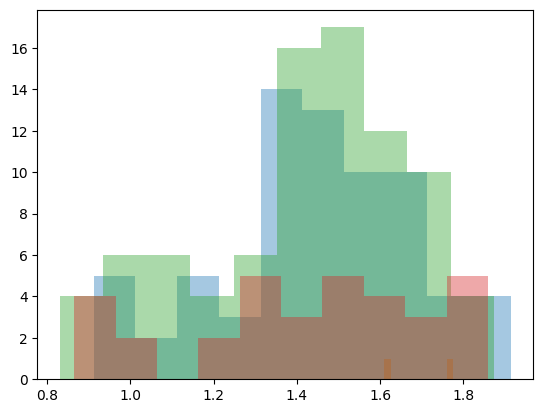

In [299]:
for group in grouped_age:
    plt.hist(group, alpha=0.4)